<a href="https://colab.research.google.com/github/riccardomarin/SpectralShapeAnalysis/blob/master/Matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ONLY FOR COLAB
# Not required in Binder

!wget -c https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
!chmod +x Miniconda3-4.5.4-Linux-x86_64.sh
!bash ./Miniconda3-4.5.4-Linux-x86_64.sh -b -f -p /usr/local
!conda install -q -y --prefix /usr/local python=3.6 ujson

import sys
sys.path.append('/usr/local/lib/python3.6/site-packages')

import ujson
print(ujson.dumps({1:2}))

!conda install -c conda-forge igl
!conda install -c conda-forge meshplot

--2020-07-30 15:01:51--  https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
installing: python-3.6.5-hc3d631a_2 ...
Python 3.6.5 :: Anaconda, Inc.
installing: ca-certificates-2018.03.07-0 ...
installing: conda-env-2.6.0-h36134e3_1 ...
installing: libgcc-ng-7.2.0-hdf63c60_3 ...
installing: libstdcxx-ng-7.2.0-hdf63c60_3 ...
installing: libffi-3.2.1-hd88cf55_4 ...
installing: ncurses-6.1-hf484d3e_0 ...
installing: openssl-1.0.2o-h20670df_0 ...
installing: tk-8.6.7-hc745277_3 ...
installing: xz-5.2.4-h14c3975_4 ...
installing: yaml-0.1.7-had09818_2 ...
installing: zlib-1.2.11-ha838bed_2 ...
installing: libedit-3.1.20170329-h6b74fdf_2 ...

In [92]:
import igl

import scipy as sp
import numpy as np
from meshplot import plot, subplot, interact
import meshplot
from scipy.sparse.linalg import eigs,eigsh
from scipy.sparse import csr_matrix
import os 
from sklearn.cluster import KMeans
import tensorflow as tf
import matplotlib.pyplot as plt

tf.__version__

'2.2.0'

In [93]:
def plot_pair(v1, v2, f1, f2, c1, c2, color_ops = {}):
    # Compute a scale factor
    M1 = igl.massmatrix(v1, f1, igl.MASSMATRIX_TYPE_VORONOI)
    M2 = igl.massmatrix(v2, f2, igl.MASSMATRIX_TYPE_VORONOI)
    scale_factor = np.sqrt(np.sum(M2)/np.sum(M1))

    # Align the shapes
    v2 = v2 - np.mean(v2,axis=0)
    v1_align = v1 * scale_factor + np.mean(v1,axis=0) + [0.7,-0.7,0.0]

    # Merge the models
    v_all = np.vstack((v1_align, v2))
    f_all = np.vstack((f1, f2 + np.max(f1)+1))
    c_all = np.vstack((c1, c2))
    
    plot(v_all, f_all, c_all, shading = color_ops)

# WKS

We will use the Wave Kernel Signature (WKS) descriptor to do the matching. Recall the formula:

$K_E(x,x) = \sum\limits_{l=1}^{\infty}e^{- \frac{(log(E) - log(\lambda_l))^2}{2\sigma^2}} \phi_l(x)^2 $

Where:
- $sigma = 7 \delta$
- $delta =  (e_{max} - e{min})/ M$
- $e_{max} = log(E_N) - 2\sigma$
- $e_{min} = log(E_1) + 2\sigma$
- $E_N$ is the max eigenvalue in absolute value
- $E_1$ is the min non-zero eigenvalue in absolute value
- $M$ is the number of WKS scales

The tasks are:
- Read the meshes, compute the LBO eigenvectors
- Define the WKS computation
- Visualize the WKS scales on meshes
- Perform the matching using WKS (Nearest-Neighbor in the descriptor space)
- Visualize the matching (and compute the error)

Are the descriptors coherent among the shapes, for different descriptor scales? Is the matching good? We can change the number of descriptors: does it impact the matching?

In [94]:
# Load Shapes
v_src, f_src = igl.read_triangle_mesh(os.path.join('.', "data", "tr_reg_089.off"))

L_src = -igl.cotmatrix(v_src, f_src)
M_src = igl.massmatrix(v_src, f_src, igl.MASSMATRIX_TYPE_VORONOI)

try:
    evals_src, evecs_src = eigsh(L_src, 200, M_src, sigma=0.0, which='LM', maxiter=1e9, tol=1.e-15)
except:
    evals_src, evecs_src = eigsh(L_src- 1e-8* scipy.sparse.identity(v_src.shape[0]), 200,
                         M_src, sigma=0.0, which='LM', maxiter=1e9, tol=1.e-15)

evals_src = evals_src.astype(np.float32)
evals_src = evals_src.astype(np.float32)

v_tar, f_tar = igl.read_triangle_mesh(os.path.join('.', "data", "tr_reg_090.off"))

L_tar = -igl.cotmatrix(v_tar, f_tar)
M_tar = igl.massmatrix(v_tar, f_tar, igl.MASSMATRIX_TYPE_VORONOI)

try:
    evals_tar, evecs_tar = eigsh(L_tar, 200, M_tar, sigma=0.0, which='LM', maxiter=1e9, tol=1.e-15)
except:
    evals_tar, evecs_tar = eigsh(L_tar- 1e-8* scipy.sparse.identity(v_tar.shape[0]), 200,
                         M_src, sigma=0.0, which='LM', maxiter=1e9, tol=1.e-15)
    
evals_src = evals_tar.astype(np.float32)
evals_src = evals_tar.astype(np.float32)

In [95]:
def WKS(vertices, faces, evals, evecs, wks_size, variance):
    # Number of vertices
    n = vertices.shape[0]
    WKS = np.zeros((n,wks_size))

    # Just for numerical stability
    evals[evals<1e-6] = 1e-6

    # log(E)
    log_E = np.log(evals).T

    # Define the energies step
    e = np.linspace(log_E[1], np.max(log_E)/1.02, wks_size)

    # Compute the sigma
    sigma = (e[1]-e[0]) * variance
    C = np.zeros((wks_size,1))

    for i in np.arange(0,wks_size):
        # Computing WKS
        WKS[:,i] = np.sum(
            (evecs)**2 * np.tile( np.exp((-(e[i] - log_E)**2) / (2*sigma**2)),(n,1)), axis=1)
        
        # Noramlization
        C[i] = np.sum(np.exp((-(e[i]-log_E)**2)/(2*sigma**2)))
        
    WKS = np.divide(WKS,np.tile(C,(1,n)).T)
    return WKS

In [96]:
# Computing the descriptors for the two shapes
d_src = WKS(v_src, f_src, evals_src, evecs_src, 100, 7)
d_tar = WKS(v_tar, f_tar, evals_tar, evecs_tar, 100, 7)

In [97]:
# Visualizing descriptors
i = 2
plot_pair(v_src, v_tar, f_src, f_tar, d_src[:,i:i+1], d_tar[:,i:i+1])

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.4032461…

In [98]:
# Nearest Neighbor
treesearch = sp.spatial.cKDTree(d_tar)
p2p = treesearch.query(d_src, k=1)[1]

In [99]:
# To see the quality of the matching we plot a function on one shape and we transfer it to the other
funz_ = (v_tar - np.min(v_tar,0))/np.tile((np.max(v_tar,0)-np.min(v_tar,0)),(np.size(v_tar,0),1));
colors = np.cos(funz_);
funz_tar = (colors-np.min(colors))/(np.max(colors) - np.min(colors));
funz_src = funz_tar[p2p]


In [104]:
# Plot and (euclidean) error evaluation
plot_pair(v_src, v_tar, f_src, f_tar, funz_src,funz_tar)
err = np.sum(np.square(v_tar - v_tar[p2p,:]))
print(err)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.4032461…

1027.097391628316


# Functional Maps

Here we will use the Functional Maps framework. Given some descriptor $D$ on the first shape and $F$ on the second, we will compute our map $C$ such that: \
$ d = (\phi_{src}^{T} A_{src} d)^T $ \
$ f = (\phi_{tar}^{T} A_{tar} f)^T $ \
$ C D = F $ \
$ C =  F D^{-1} $

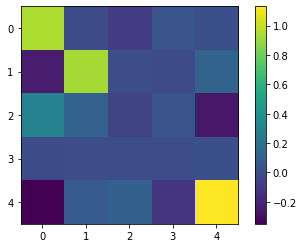

In [105]:
# WKS
n_evals = 5
n_desc = 3
D = (np.matmul(evecs_src[:,0:n_evals].T, np.matmul(M_src.todense() , d_src[:,0:n_desc])))
F = (np.matmul(evecs_tar[:,0:n_evals].T, np.matmul(M_tar.todense() , d_tar[:,0:n_desc])))
C =  np.matmul(F,np.linalg.pinv(D))

plt.imshow(C)
plt.colorbar()
plt.show()

In [108]:
# Compute p2p correspondence
treesearch = sp.spatial.cKDTree(evecs_tar[:,0:n_evals])
p2p = treesearch.query(np.matmul(evecs_src[:,0:n_evals], C), k=1)[1]

In [109]:
plot_pair(v_src, v_tar, f_src, f_tar, funz_src,funz_tar)
err = np.sum(np.square(v_tar - v_tar[p2p,:]))
print(err)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.4032461…

1027.097391628316


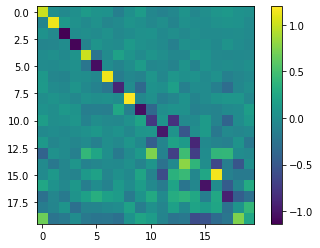

In [110]:
# landmarks
n_land = 45
n_evals = 20
step = np.int(np.ceil(v_src.shape[0] / n_land))
a = np.arange(0,v_src.shape[0],step)

landmarks = np.zeros((v_src.shape[0], a.size))
landmarks[a,np.arange(a.size)] = 1

D = (np.matmul(evecs_src[:,0:n_evals].T, np.matmul(M_src.todense() , landmarks[:,0:n_land])))
F = (np.matmul(evecs_tar[:,0:n_evals].T, np.matmul(M_tar.todense() , landmarks[:,0:n_land])))
C =  np.matmul(F,np.linalg.pinv(D))

plt.imshow(C)
plt.colorbar()
plt.show()

In [111]:
treesearch = sp.spatial.cKDTree(evecs_tar[:,0:n_evals])
p2p = treesearch.query(np.matmul(evecs_src[:,0:n_evals], C), k=1)[1]
plot_pair(v_src, v_tar, f_src, f_tar, funz_src,funz_tar)
err = np.sum(np.square(v_tar - v_tar[p2p,:]))
print(err)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.4032461…

257.354553139738


Here we implement Functional Maps as an optimization problem

In [112]:
# Computing descriptors
n_land =  20
n_wks  =  2

n_evals = 20

# Landmarks
step = np.int(np.ceil(v_src.shape[0] / n_land))
a = np.arange(0,v_src.shape[0],step)
landmarks = np.zeros((v_src.shape[0], a.size))
landmarks[a,np.arange(a.size)] = 1

# WKS
d_src = WKS(v_src, f_src, evals_src, evecs_src, n_wks, 7)
d_tar = WKS(v_tar, f_tar, evals_tar, evecs_tar, n_wks, 7)

# Optimization Process
desc_src = np.hstack((landmarks,d_src))
desc_tar = np.hstack((landmarks,d_tar))

# Descriptor normalization
no = np.sqrt(np.diag(np.matmul(M_src.T.__matmul__(desc_src).T, desc_src)))
no_s = np.tile(no.T,(v_src.shape[0],1))
no_t = np.tile(no.T,(v_tar.shape[0],1))
fct_src = np.divide(desc_src,no_s)
fct_tar = np.divide(desc_tar,no_t)

# Coefficents of the obtained descriptors
Fct_src = np.matmul(M_src.T.__matmul__(evecs_src[:, 0:n_evals]).T, fct_src)
Fct_tar = np.matmul(M_tar.T.__matmul__(evecs_tar[:, 0:n_evals]).T, fct_tar)

# The relation between the two constant functions can be computed in a closed form
constFct = np.zeros((n_evals,1))
constFct[0, 0] = np.sign(evecs_src[0, 0] * evecs_tar[0, 0]) * np.sqrt(np.sum(M_tar)/np.sum(M_src))

# Different way to compute Laplacian commutativity
# Dlb = (np.tile(evals_src[0:n_evals], (n_evals, 1)) - np.tile(evals_tar[0:n_evals].T, (n_evals, 1)))**2
# Dlb = np.float32(Dlb/tf.reduce_sum((Dlb**2)))

Play with different energy weights.

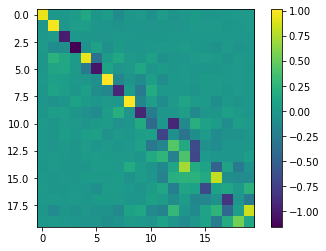

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.4032461…

230.65661710726357


In [120]:
# Energy weights
a = 1e-1 # Descriptors preservation
c = 1e-8 # Commutativity with Laplacian

# Optimizer
adam = tf.keras.optimizers.Adam(1e-1) # Optimization technique

# Define tensorflow objects
fs = tf.constant(Fct_src, dtype=tf.float32)
ft = tf.constant(Fct_tar, dtype=tf.float32)
evals = tf.constant(tf.linalg.tensor_diag(np.reshape(np.float32(evals_src[0:n_evals]), (n_evals,))), dtype=tf.float32)
evalt = tf.constant(tf.linalg.tensor_diag(np.reshape(np.float32(evals_tar[0:n_evals]), (n_evals,))), dtype=tf.float32)

# Initialize C
C_ini = np.zeros((n_evals,n_evals))
C_ini[0,0]=constFct[0,0]
C = tf.Variable(tf.zeros((n_evals,n_evals), dtype=tf.float32))
C.assign(C_ini)
trainable_vars = [C]

for i in np.arange(0,1000):
    with tf.GradientTape() as tape:
        loss1 = a * tf.reduce_sum(((tf.matmul(C, fs) - ft) ** 2)) / 2
        loss2 = c * tf.reduce_sum((tf.matmul(C, evals) - tf.matmul(evalt,C))**2) #tf.reduce_sum(((C ** 2) * Dlb) / 2)
        #loss3 = 1e-6 *  tf.reduce_sum(tf.square(tf.matmul(tf.transpose(C),C) - tf.eye(n_evals)))
        loss = loss1  + loss2# + loss3

    # Apply gradient
    grad = tape.gradient(loss,trainable_vars)
    tmp = adam.apply_gradients(zip(grad,trainable_vars))

C = C.numpy()
plt.imshow(C)
plt.colorbar()
plt.show()

treesearch = sp.spatial.cKDTree(evecs_tar[:,0:n_evals])
p2p = treesearch.query(np.matmul(evecs_src[:,0:n_evals], C), k=1)[1]
plot_pair(v_src, v_tar, f_src, f_tar, funz_src,funz_tar)
err = np.sum(np.square(v_src - v_src[p2p,:]))
print(err)

A common post-processing is ICP refinement. The main idea is that we can think to our spectral embedding as N-dimensional pointclouds. If my change of basis $C$ brings the two close enough, we can try to improve the alignment using the rigid registration algorithm called Iterative Closest Point (ICP). 
It is based on two steps. Given a pointcloud $M$ that I want to align to $N$:
- Computing the Nearest Neighbor matching between $M$ and $N$
- Computing the optimal roto-translation via SVD that align $M$ with $N$ using the given NN correspondence
- Iterate until convergence

It is prone to get stuck in local-minima, but if the pointclouds are alrady close enough, it can significatly improve the solution.

ICP refine...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


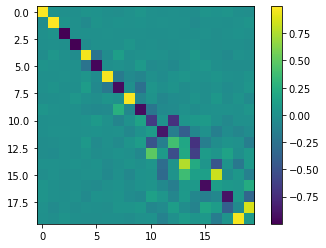

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.4032461…

193.92387244139638


In [122]:
import scipy
print('ICP refine...')
for k in np.arange(0,5):
    treesearch = scipy.spatial.cKDTree(np.matmul(C,evecs_src[:,0:n_evals].T).T)
    matches = treesearch.query(evecs_tar[:,0:n_evals], k=1)[1]
    W = np.linalg.lstsq(evecs_tar[:, 0:n_evals],evecs_src[matches, 0:n_evals])[0]
    d = np.linalg.svd(W)
    C_ICP = np.matmul(np.matmul(d[0], np.eye(n_evals)), d[2])

plt.imshow(C_ICP)
plt.colorbar()
plt.show()

treesearch = sp.spatial.cKDTree(evecs_tar[:,0:n_evals])
p2p = treesearch.query(np.matmul(evecs_src[:,0:n_evals], C_ICP), k=1)[1]
plot_pair(v_src, v_tar, f_src, f_tar, funz_src,funz_tar)
err = np.sum(np.square(v_tar - v_tar[p2p,:]))
print(err)

Finally, here we anticipate the ZoomOut refinement that you will see tomorrow. This let to compute a high dimensional $C$. It is based on two iterative steps.Given a $C$ of dimension $n \times n$:
- Convert it into a dense correspondence
- Convert the dense correspondence into a $C$ of dimension $(n+1) \times (n+1)$ 
These two simple steps produce an impressive improvement in the matching quality.

In [129]:
C_iter = C_ICP
n_iter = 20
for i in np.arange(0,n_iter):
  treesearch = sp.spatial.cKDTree(evecs_tar[:,0:n_evals+i])
  p2p = treesearch.query(np.matmul(evecs_src[:,0:n_evals+i], C_iter), k=1)[1]

  C_iter = np.matmul(np.linalg.pinv(evecs_src[p2p,0:n_evals+i+1]),evecs_tar[:,0:n_evals+i+1])



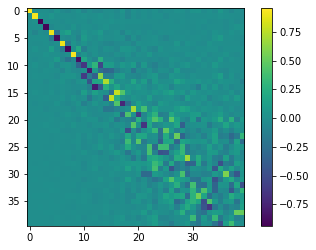

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.4032461…

838.1596828386763


In [130]:
plt.imshow(C_iter)
plt.colorbar()
plt.show()
treesearch = sp.spatial.cKDTree(evecs_src[:,0:n_evals+n_iter])
p2p = treesearch.query(np.matmul(evecs_tar[:,0:n_evals+n_iter], C_iter), k=1)[1]
plot_pair(v_src, v_tar, f_src, f_tar, funz_src,funz_tar)
err = np.sum(np.square(v_tar - v_tar[p2p,:]))
print(err)

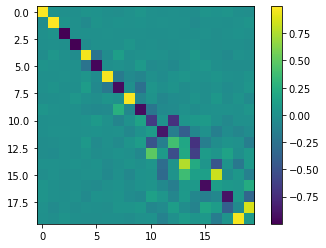

In [133]:
plt.imshow(C_ICP)
plt.colorbar()
plt.show()